In [219]:
# pytorch code from robert yang:
# https://github.com/neurogym/ngym_usage/tree/master/yang19
import numpy as np
import torch
import torch.nn as nn
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import scipy as scipy
import numpy as np
from scipy import sparse
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
torch.set_default_tensor_type(torch.DoubleTensor)

class CTRNN(nn.Module):
    
    """Continuous-time RNN.
    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        mask: N_h x N_h mask either 2d or 1d
    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, mask = None, **kwargs):

        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        self.mask = mask
        
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.reset_parameters()
        
        #initialize hidden to hidden weight matrix using the mask
        if mask is None:
            temp = 0
        else:
            self.h2h.weight.data = self.h2h.weight.data*torch.nn.Parameter(mask)

    def reset_parameters(self):
        nn.init.eye_(self.h2h.weight)
        self.h2h.weight.data *= 0.5

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.relu(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        output = torch.stack(output, dim=0)
        return output, hidden



class RNNNet(nn.Module):
    
    """Recurrent network model.
    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """

    def __init__(self, input_size, hidden_size, output_size, mask, **kwargs):
        super().__init__()

        #Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, mask = mask, **kwargs)
        #readout layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #hidden dynamics
        rnn_activity, _ = self.rnn(x)
        #readout
        out = self.fc(rnn_activity)
        return out, rnn_activity

# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Net, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.linear = nn.Linear(hidden_size, output_size)
#
#     def forward(self, x):
#         out, hidden = self.lstm(x)
#         x = self.linear(out)
#         return x


# TODO: Make this into a function in neurogym

def get_performance(net, env, num_trial=1000, device='cpu'):
    perf = 0

    for i in range(num_trial):

        env.new_trial()
        ob, gt = env.ob, env.gt
        ob = ob[:, np.newaxis, :]  # Add batch axis
        inputs = torch.from_numpy(ob).type(torch.DoubleTensor)
        action_pred, _ = net(inputs)
        action_pred = action_pred.detach().cpu().numpy()
        action_pred = np.argmax(action_pred, axis=-1)
        perf += gt[-1] == action_pred[-1, 0]

    perf /= num_trial
    return perf





cpu


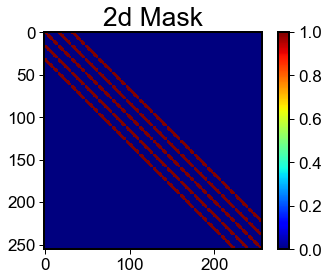

In [232]:
"""Train networks for reproducing multi-cognitive-tasks from
Task representations in neural networks trained to perform many cognitive tasks
https://www.nature.com/articles/s41593-018-0310-2
"""

import os
import time
import numpy as np
import torch
import torch.nn as nn
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
import math
import scipy as scipy
import numpy as np
from scipy import sparse
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def mask2d(N_x,N_y,cutoff,periodic):
    x1 = np.linspace(-(N_x)//2,(N_x)//2-1,N_x)
    x1 = np.expand_dims(x1,axis=1)
    x2 = np.linspace(-(N_y)//2,(N_y)//2-1,N_y)
    x2 = np.expand_dims(x2,axis=1)
    x_coordinates = np.expand_dims(np.repeat(x1,N_y,axis = 0).reshape(N_x,N_y).transpose().flatten(),axis=1)
    y_coordinates = np.expand_dims(np.repeat(x2,N_x,axis = 0).reshape(N_x,N_y).flatten(),axis=1)
    
    #calculate torus distance on 2d sheet
    distances_x = cdist(x_coordinates,x_coordinates)
    distances_y = cdist(y_coordinates,y_coordinates)
    
    if(periodic==True):
        distances_y = np.minimum(N_y-distances_y,distances_y)
        distances_x = np.minimum(N_x-distances_x,distances_x)
    
    distances = np.sqrt(np.square(distances_x) + np.square(distances_y))
    dist = distances.reshape(N_y,N_x,N_y,N_x)
    dist = dist.reshape(N_x*N_y,N_x*N_y)
    dist[dist<cutoff] = 1
    dist[dist>cutoff-1] = 0
    return dist

def sparsemask2d(N_x,N_y,sparsity):
    elements = np.random.uniform(0,1,(N_x,N_y))
    mask = (elements<sparsity).astype(int)
    return mask

#sparsity for d=2 is 0.03228759765625
#sparsity for d=3 is 0.0836
#sparsity for d=4 is 0.1423

#h2h anatomical mask
N_x = 16
N_y = 16
periodic = False
d = 3
sparsity = 0.0836

plt.imshow(mask2d(N_x,N_y,d,False),cmap ='jet');plt.colorbar();plt.title('2d Mask')
#convert to pytorch tensor from numpy
mask2d = torch.from_numpy(mask2d(N_x,N_y,d,False))
mask2d = mask2d.double()
'''
plt.imshow(sparsemask2d(N_x*N_y,N_y*N_x,sparsity),cmap ='jet');plt.colorbar();plt.title('Sparse 2d Mask')
#convert to pytorch tensor from numpy
mask2d = torch.from_numpy(sparsemask2d(N_x*N_y,N_y*N_x,sparsity))
'''
mask2d = mask2d.double()

# Environment parameters
kwargs = {'dt': 100}
# kwargs = {'dt': 100, 'sigma': 0, 'dim_ring': 2, 'cohs': [0.1, 0.3, 0.6, 1.0]}
seq_len = 100

# Make supervised dataset using neurogym

tasks = ngym.get_collection('yang19')
envs = [gym.make(task, **kwargs) for task in tasks]
schedule = RandomSchedule(len(envs))
env = ScheduleEnvs(envs, schedule=schedule, env_input=True)
dataset = ngym.Dataset(env, batch_size=4, seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#initialize the RNN model
model = RNNNet(input_size=ob_size, hidden_size=256, output_size=act_size,
               dt=env.dt, mask = mask2d).to(device)

#loss function
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print_step = 200
running_loss = 0.0
running_task_time = 0
running_train_time = 0

In [233]:
losses = []
perfs = []
for i in range(40000):

    task_time_start = time.time()
    inputs, labels = dataset()

    running_task_time += time.time() - task_time_start
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    train_time_start = time.time()
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs, _ = model(inputs.double())
    #calculate loss
    loss = criterion(outputs.view(-1, act_size), labels)
    #do backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    #apply anatomical mask on h2h weights
    model.rnn.h2h.weight.data = model.rnn.h2h.weight.data*(mask2d)
        
        
    running_train_time += time.time() - train_time_start
    #print statistics
    running_loss += loss.item()       
    if i % print_step == (print_step - 1):
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / print_step))
        losses.append(running_loss/print_step)
        running_loss = 0.0
        
        if True:
            print('Task/Train time {:0.1f}/{:0.1f} ms/step'.format(

                    running_task_time / print_step * 1e3,

                    running_train_time / print_step * 1e3))

            running_task_time, running_train_time = 0, 0
        perf = get_performance(model, env, num_trial=200, device=device)
        perfs.append(perf)
        print('{:d} perf: {:0.2f}'.format(i + 1, perf))
        fname = os.path.join('/Users/mikailkhona/multitask','files', 'locald3model.pt')
        torch.save(model.state_dict(), fname)
        
print('Finished Training')
np.save('/Users/mikailkhona/multitask/files/locald3modellosscurve.npy',losses)
np.save('/Users/mikailkhona/multitask/files/locald3modelperfcurve.npy',perfs)
#np.save('/Users/mikailkhona/multitask/files/sparsed3modellosscurve.npy',losses)
#np.save('/Users/mikailkhona/multitask/files/sparsed3modelperfcurve.npy',perfs)

200 loss: 0.79178
Task/Train time 10.0/49.3 ms/step
200 perf: 0.22
400 loss: 0.43911
Task/Train time 9.4/43.9 ms/step
400 perf: 0.43
600 loss: 0.34491
Task/Train time 9.7/45.4 ms/step
600 perf: 0.60
800 loss: 0.29351
Task/Train time 8.8/40.5 ms/step
800 perf: 0.59
1000 loss: 0.25624
Task/Train time 8.8/40.5 ms/step
1000 perf: 0.68
1200 loss: 0.22069
Task/Train time 8.8/40.8 ms/step
1200 perf: 0.66
1400 loss: 0.19713
Task/Train time 8.9/40.5 ms/step
1400 perf: 0.74
1600 loss: 0.17404
Task/Train time 8.6/40.7 ms/step
1600 perf: 0.73
1800 loss: 0.17195
Task/Train time 8.6/39.6 ms/step
1800 perf: 0.64
2000 loss: 0.16149
Task/Train time 8.7/41.0 ms/step
2000 perf: 0.74
2200 loss: 0.15045
Task/Train time 8.8/40.9 ms/step
2200 perf: 0.75
2400 loss: 0.14035
Task/Train time 8.7/40.2 ms/step
2400 perf: 0.74
2600 loss: 0.12770
Task/Train time 8.6/40.2 ms/step
2600 perf: 0.83
2800 loss: 0.11999
Task/Train time 8.8/40.1 ms/step
2800 perf: 0.84
3000 loss: 0.11814
Task/Train time 8.8/40.9 ms/step
300

23800 perf: 0.96
24000 loss: 0.04787
Task/Train time 9.1/41.2 ms/step
24000 perf: 0.94
24200 loss: 0.04424
Task/Train time 8.7/39.7 ms/step
24200 perf: 0.94
24400 loss: 0.05065
Task/Train time 8.9/40.9 ms/step
24400 perf: 0.92
24600 loss: 0.04416
Task/Train time 8.5/40.8 ms/step
24600 perf: 0.93
24800 loss: 0.04898
Task/Train time 8.7/41.0 ms/step
24800 perf: 0.94
25000 loss: 0.04894
Task/Train time 8.6/40.7 ms/step
25000 perf: 0.95
25200 loss: 0.04870
Task/Train time 8.6/40.9 ms/step
25200 perf: 0.92
25400 loss: 0.04969
Task/Train time 8.9/41.5 ms/step
25400 perf: 0.95
25600 loss: 0.04549
Task/Train time 8.6/40.2 ms/step
25600 perf: 0.95
25800 loss: 0.04705
Task/Train time 8.5/40.5 ms/step
25800 perf: 0.95
26000 loss: 0.05000
Task/Train time 8.9/40.6 ms/step
26000 perf: 0.95
26200 loss: 0.04422
Task/Train time 8.8/40.9 ms/step
26200 perf: 0.97
26400 loss: 0.04646
Task/Train time 8.5/40.9 ms/step
26400 perf: 0.94
26600 loss: 0.04787
Task/Train time 10.0/46.8 ms/step
26600 perf: 0.95
26

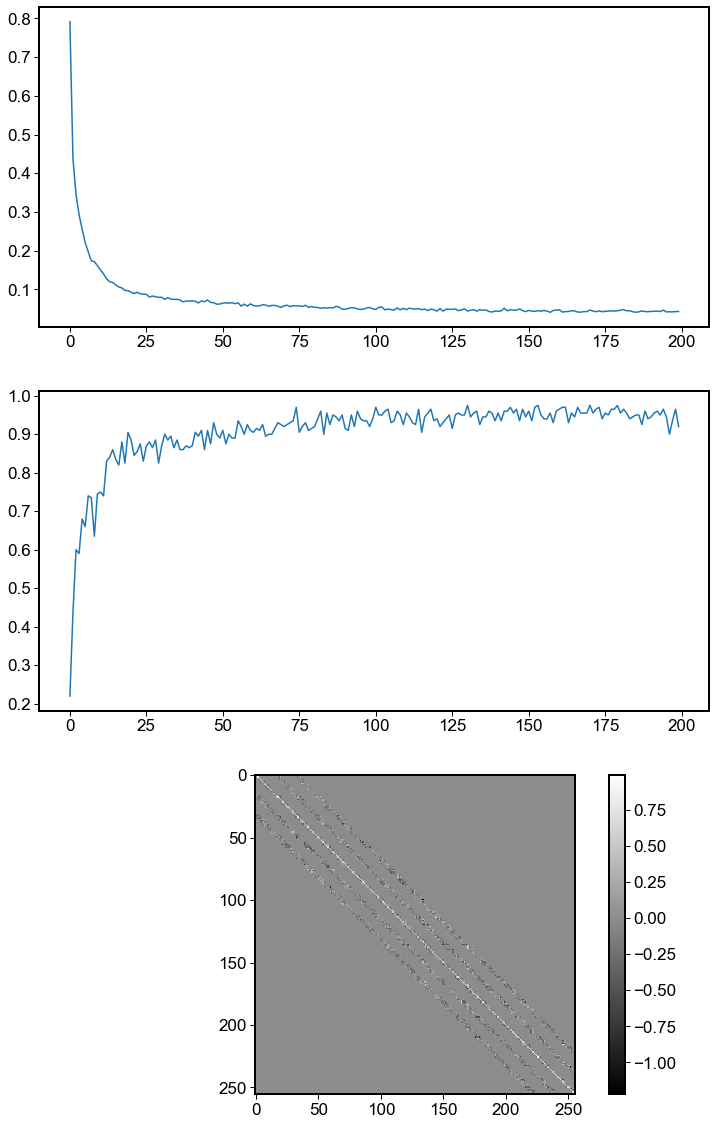

In [234]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['font.size']=22.
plt.rcParams['axes.labelsize']=22.
plt.rcParams['legend.fontsize']=20.
plt.rcParams['savefig.dpi']=200
plt.rcParams['xtick.labelsize']=17.
plt.rcParams['ytick.labelsize']=17.
plt.rcParams['xtick.minor.size']=3
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.minor.size']=3
plt.rcParams['ytick.major.size']=5
plt.rcParams['xtick.major.width']=1.
plt.rcParams['xtick.minor.width']=1.
plt.rcParams['ytick.major.width']=1.
plt.rcParams['ytick.minor.width']=1.
plt.rcParams['axes.linewidth']=2.

fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(12, 20),sharex=True,gridspec_kw={'height_ratios': [1,1,1]})

plt.subplot(311)
plt.plot(np.array(losses))

plt.subplot(312)
plt.plot(np.array(perfs))

plt.subplot(313)
plt.imshow((model.rnn.h2h.weight.data).detach().numpy(),cmap = 'gray');plt.colorbar()
#plt.savefig('sparse_d3model.pdf')
plt.savefig('local_d3model.pdf')

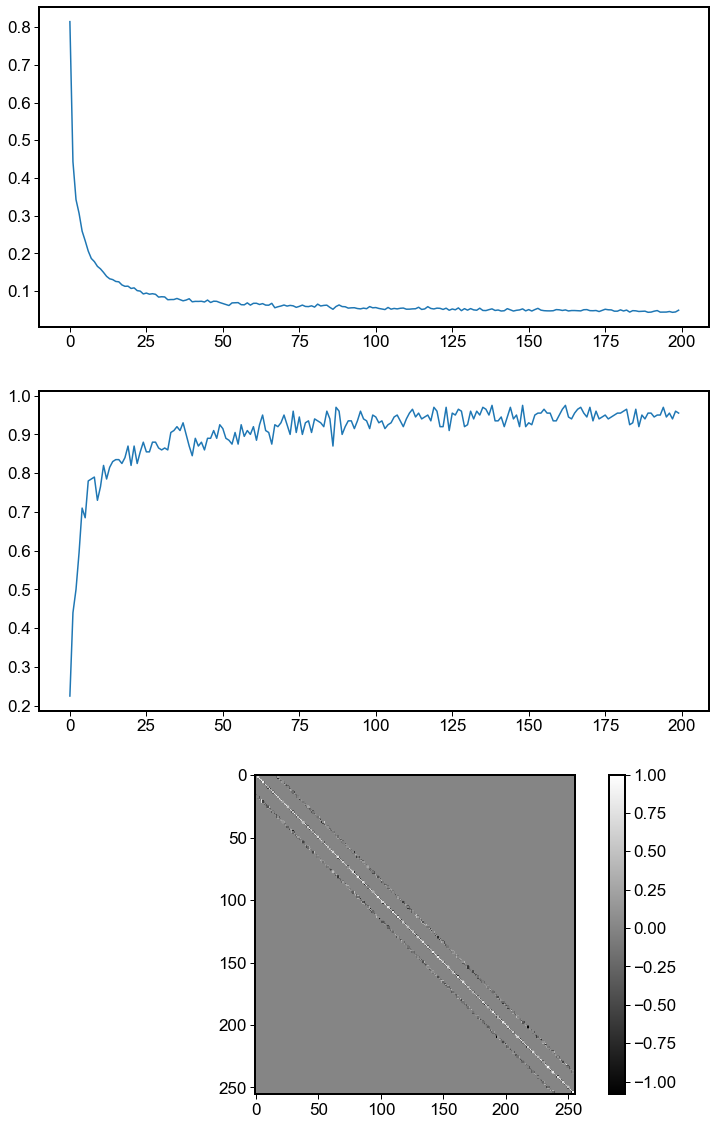

In [191]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['font.size']=22.
plt.rcParams['axes.labelsize']=22.
plt.rcParams['legend.fontsize']=20.
plt.rcParams['savefig.dpi']=200
plt.rcParams['xtick.labelsize']=17.
plt.rcParams['ytick.labelsize']=17.
plt.rcParams['xtick.minor.size']=3
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.minor.size']=3
plt.rcParams['ytick.major.size']=5
plt.rcParams['xtick.major.width']=1.
plt.rcParams['xtick.minor.width']=1.
plt.rcParams['ytick.major.width']=1.
plt.rcParams['ytick.minor.width']=1.
plt.rcParams['axes.linewidth']=2.

fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(12, 20),sharex=True,gridspec_kw={'height_ratios': [1,1,1]})

plt.subplot(311)
plt.plot(np.array(losses))

plt.subplot(312)
plt.plot(np.array(perfs))

plt.subplot(313)
plt.imshow((model.rnn.h2h.weight.data).detach().numpy(),cmap = 'gray');plt.colorbar()
plt.savefig('local_d2model.pdf')

Average performance 1.00 for task yang19.go-v0
Average performance 1.00 for task yang19.rtgo-v0
Average performance 1.00 for task yang19.dlygo-v0
Average performance 1.00 for task yang19.anti-v0
Average performance 1.00 for task yang19.rtanti-v0
Average performance 1.00 for task yang19.dlyanti-v0
Average performance 0.86 for task yang19.dm1-v0
Average performance 0.90 for task yang19.dm2-v0
Average performance 0.88 for task yang19.ctxdm1-v0
Average performance 0.90 for task yang19.ctxdm2-v0
Average performance 0.87 for task yang19.multidm-v0
Average performance 0.96 for task yang19.dlydm1-v0
Average performance 0.94 for task yang19.dlydm2-v0
Average performance 0.95 for task yang19.ctxdlydm1-v0
Average performance 0.91 for task yang19.ctxdlydm2-v0
Average performance 0.84 for task yang19.multidlydm-v0
Average performance 0.97 for task yang19.dms-v0
Average performance 0.98 for task yang19.dnms-v0
Average performance 1.00 for task yang19.dmc-v0
Average performance 1.00 for task yang19.d

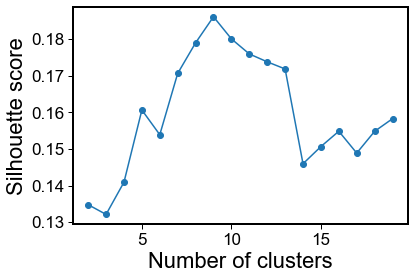

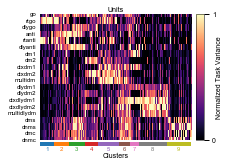

In [236]:
"""Analyze."""
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import gym
import neurogym as ngym
from neurogym.wrappers.block import MultiEnvs
#from models import RNNNet, get_performance
import scipy as scipy
import numpy as np
from scipy import sparse
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def mask2d(N_x,N_y,cutoff,periodic):
    x1 = np.linspace(-(N_x)//2,(N_x)//2-1,N_x)
    x1 = np.expand_dims(x1,axis=1)
    x2 = np.linspace(-(N_y)//2,(N_y)//2-1,N_y)
    x2 = np.expand_dims(x2,axis=1)
    x_coordinates = np.expand_dims(np.repeat(x1,N_y,axis = 0).reshape(N_x,N_y).transpose().flatten(),axis=1)
    y_coordinates = np.expand_dims(np.repeat(x2,N_x,axis = 0).reshape(N_x,N_y).flatten(),axis=1)
    
    #calculate torus distance on 2d sheet
    distances_x = cdist(x_coordinates,x_coordinates)
    distances_y = cdist(y_coordinates,y_coordinates)
    
    if(periodic==True):
        distances_y = np.minimum(N_y-distances_y,distances_y)
        distances_x = np.minimum(N_x-distances_x,distances_x)
    
    distances = np.sqrt(np.square(distances_x) + np.square(distances_y))
    dist = distances.reshape(N_y,N_x,N_y,N_x)
    dist = dist.reshape(N_x*N_y,N_x*N_y)
    dist[dist<cutoff] = 1
    dist[dist>cutoff-1] = 0
    return dist
    

# Environment

timing = {'fixation': ('constant', 500)}
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100
tasks = ngym.get_collection('yang19')
envs = [gym.make(task, **kwargs) for task in tasks]
env = MultiEnvs(envs, env_input=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = RNNNet(input_size=53, hidden_size=256, output_size=17,
             dt=env.dt, mask = torch.from_numpy(mask2d(16,16,3,False))).to(device)
fname = os.path.join('/Users/mikailkhona/multitask','files', 'locald3model.pt')
#fname = os.path.join('files', 'model.pt')
net.load_state_dict(torch.load(fname, map_location=torch.device(device)))

def get_activity(net, env, num_trial=1000):

    """Get activity of equal-length trials"""

    trial_list = list()
    activity_list = list()

    for i in range(num_trial):
        env.new_trial()
        ob = env.ob
        ob = ob[:, np.newaxis, :]  # Add batch axis
        inputs = torch.from_numpy(ob).type(torch.DoubleTensor).to(device)
        action_pred, activity = net(inputs)
        activity = activity.detach().numpy()
        trial_list.append(env.trial)
        activity_list.append(activity)
    activity = np.concatenate(activity_list, axis=1)
    return activity, trial_list

# Get performance

for i in range(20):
    env.set_i(i)
    perf = get_performance(net, env, num_trial=200)
    print('Average performance {:0.2f} for task {:s}'.format(perf, tasks[i]))

# Compute and Plot task variance
task_variance_list = list()

for i in range(20):
    env.set_i(i)
    activity, trial_list = get_activity(net, env, num_trial=500)
    # Compute task variance
    task_variance = np.var(activity, axis=1).mean(axis=0)
    task_variance_list.append(task_variance)

task_variance = np.array(task_variance_list)  # (n_task, n_units)
thres = 1e-6
task_variance = task_variance[:, task_variance.sum(axis=0)>thres]
norm_task_variance = task_variance / np.max(task_variance, axis=0)

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

X = norm_task_variance.T
silhouette_scores = list()
n_clusters = np.arange(2, 20)

for n in n_clusters:
    cluster_model = AgglomerativeClustering(n_clusters=n)
    labels = cluster_model.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

plt.figure()
plt.plot(n_clusters, silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

n_cluster = n_clusters[np.argmax(silhouette_scores)]
cluster_model = AgglomerativeClustering(n_clusters=n_cluster)
labels = cluster_model.fit_predict(X)

# Sort clusters by its task preference (important for consistency across nets)

label_prefs = [np.argmax(norm_task_variance[:, labels==l].sum(axis=1)) for l in set(labels)]
ind_label_sort = np.argsort(label_prefs)
label_prefs = np.array(label_prefs)[ind_label_sort]

# Relabel

labels2 = np.zeros_like(labels)
for i, ind in enumerate(ind_label_sort):
    labels2[labels==ind] = i
labels = labels2




# Sort neurons by labels
ind_sort = np.argsort(labels)
labels = labels[ind_sort]
norm_task_variance = norm_task_variance[:, ind_sort]


# Plot Normalized Variance

figsize = (3.5,2.5)
rect = [0.25, 0.2, 0.6, 0.7]
rect_color = [0.25, 0.15, 0.6, 0.05]
rect_cb = [0.87, 0.2, 0.03, 0.7]
tick_names = [task[len('yang19.'):-len('-v0')] for task in tasks]
fs = 6
labelpad = 13

vmin, vmax = 0, 1

fig = plt.figure(figsize=figsize)
ax = fig.add_axes(rect)
im = ax.imshow(norm_task_variance, cmap='magma',
               aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)

plt.yticks(range(len(tick_names)), tick_names,
           rotation=0, va='center', fontsize=fs)
plt.xticks([])
plt.title('Units', fontsize=7, y=0.97)
plt.xlabel('Clusters', fontsize=7, labelpad=labelpad)
ax.tick_params('both', length=0)

for loc in ['bottom','top','left','right']:
    ax.spines[loc].set_visible(False)

ax = fig.add_axes(rect_cb)
cb = plt.colorbar(im, cax=ax, ticks=[vmin,vmax])
cb.outline.set_linewidth(0.5)
clabel = 'Normalized Task Variance'

cb.set_label(clabel, fontsize=7, labelpad=0)
plt.tick_params(axis='both', which='major', labelsize=7)

# Plot color bars indicating clustering

cmap = matplotlib.cm.get_cmap('tab10')
ax = fig.add_axes(rect_color)

for il, l in enumerate(np.unique(labels)):
    color = cmap(il % 10)
    ind_l = np.where(labels==l)[0][[0, -1]]+np.array([0,1])

    ax.plot(ind_l, [0,0], linewidth=4, solid_capstyle='butt',
            color=color)
    ax.text(np.mean(ind_l), -0.5, str(il+1), fontsize=6,
            ha='center', va='top', color=color)

ax.set_xlim([0, len(labels)])
ax.set_ylim([-1, 1])
ax.axis('off')
#plt.savefig('Clusterssparsed3model.pdf')
plt.savefig('Clusterslocald3model.pdf')

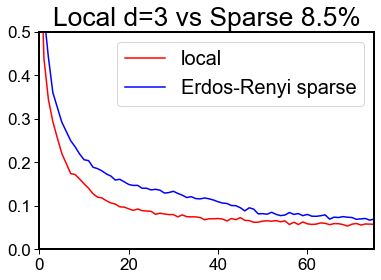

In [246]:
x = np.load('/Users/mikailkhona/multitask/files/locald3modellosscurve.npy')
y = np.load('/Users/mikailkhona/multitask/files/sparsed3modellosscurve.npy')
plt.plot(x,color = 'red',label = 'local')
plt.plot(y,color = 'blue',label = 'Erdos-Renyi sparse')
plt.legend()
plt.ylim(0,0.5)
plt.xlim(0,75)
plt.title('Local d=3 vs Sparse 8.5%')
plt.savefig('d3sparsevslocal.pdf')

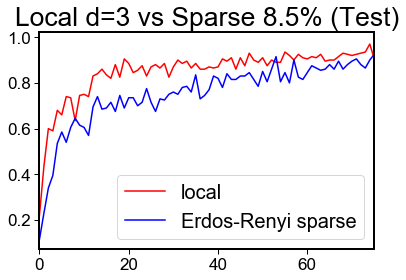

In [248]:
x = np.load('/Users/mikailkhona/multitask/files/locald3modelperfcurve.npy')
y = np.load('/Users/mikailkhona/multitask/files/sparsed3modelperfcurve.npy')
plt.plot(x,color = 'red',label = 'local')
plt.plot(y,color = 'blue',label = 'Erdos-Renyi sparse')
plt.legend()

plt.xlim(0,75)
plt.title('Local d=3 vs Sparse 8.5% (Test)')
plt.savefig('perfsd3sparsevslocal.pdf')